In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import collections
import gzip
import numpy as np
import os
import phate
import time

import pandas as pd
import pickle

from collections import defaultdict
import itertools

# Interactive HTML tools
from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.palettes import Category20b
from bokeh.palettes import Category20
from bokeh.palettes import Category10
from bokeh.palettes import PRGn
from bokeh.palettes import Set1

# Machine-learning and dimensionality reduction tools
import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA as PCA # We'll use this to check our implementation
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS

import umap

In [2]:
# Function to save objects using pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [3]:
# Note: PLINK command used to merged data
# sort nhgri_coriell_affy_6_20140825_genotypes.bim > nhgri_coriell_affy_6_20140825_genotypes_sorted.bim
# sort HRS_CLEAR.bim > HRS_CLEAR_sorted.bim

# comm -12 nhgri_coriell_affy_6_20140825_genotypes_sorted.bim HRS_CLEAR_sorted.bim > common_snps_2.txt
# plink --bfile merged_1000G_HRS --pca 200 --out merged_1000G_HRS_pca

data_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'

# Define the files we'll be using
pc_file = 'merged_1000G_HRS_pca.eigenvec'

#aux_path = os.path.join(hrs_data_dir, aux_file)
pc_path = os.path.join(data_dir, pc_file)

# Import auxiliary data. Contains IDs and demographic information.
# NOTE: The auxiliary data is sorted in an order different from the PC data.
#aux_data = []
#with open(aux_path) as input_file:
#    for line in input_file:
#        aux_data.append(line.strip().split(','))

# Import PC data. This data must be converted to an array.
with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array = np.array(pca_data).astype(np.float)

In [4]:
pca_data_array.shape

(15904, 200)

# Importing auxiliary data

For labelling we need to import auxiliary dataset from the 1000G and HRS datasets. The 1000G dataset is straightforward.

In [5]:
# Import 1000G auxiliary data
%store -r continents
%store -r pop_by_continent
%store -r pop
%store -r indices_of_population_members
%store -r name_by_code
%store -r continent_by_population
%store -r individuals
%store -r population_by_individual
%store -r individuals_by_population
%store -r populations
%store -r color_dict

The HRS data needs a bit more work as the variables aren't explicitly defined. We can import the dataset from the HRS notebook and then define values here as needed.

In [6]:
# Import HRS auxiliary data
%store -r aux_data_hrs
%store -r hisp_dict
%store -r hisp_dict_rev
%store -r mex_dict
%store -r mex_dict_rev
%store -r race_dict
%store -r race_dict_rev
%store -r brn_dict
%store -r brn_dict_rev
%store -r racedb_dict
%store -r racedb_dict_rev

%store -r hrs_joined

In [28]:
%store -r color_dict_born
%store -r color_dict_race_hisp
%store -r color_dict_race_hisp_mex

In [22]:
# Labels for the HRS data aren't as clear - import the code to define those as well.
# These auxiliary data sets will define how we label the observations

# Columns are:
# 0 = ID, 1 = Family ID, 2 = Birth Year
# 3 = Hispanic, 4 = Detailed Hispanic, 5 = Race, 6 = Birth Region, 7 = Birth region name
# 10= dbGaP race (Note: Black != AfrAm and White != Not_AfrAm)

# Create multiple types of categorization based on variables to include
aux_data_1 = [] # 1 - Birth region, race, Hispanic status, Mexican status
aux_data_2 = [] # 2 - Race, Hispanic status, Mexican status
aux_data_3 = [] # 3 - Birth region, race
aux_data_4 = [] # 4 - Race, Hispanic status
aux_data_5 = [] # 5 - Birth region
aux_data_6 = [] # 6 - Birth region, Hispanic status, Mexican status
aux_data_7 = [] # 7 - Birth region, Hispanic status

individuals_hrs = []

aux_data_dict_1 = defaultdict(list)
aux_data_dict_2 = defaultdict(list)
aux_data_dict_3 = defaultdict(list)
aux_data_dict_4 = defaultdict(list)
aux_data_dict_5 = defaultdict(list)
aux_data_dict_6 = defaultdict(list)
aux_data_dict_7 = defaultdict(list)

# Get the lists (skip the first row as it's a header)
for a in aux_data_hrs[1:]:
#for a in aux_data_dict[subset][0:]:
    individuals_hrs.append(a[0])
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]    
    aux_data_1.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_2.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]]])]
    aux_data_3.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]]])]
    aux_data_4.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]]])]
    aux_data_5.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_6.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], hisp_dict[a[3]]])]
    aux_data_7.append(temp_element)

In [23]:
aux_to_use = aux_data_2

In [24]:
# We must define the population dictionary we wish to use
# The following gives us a collection of all categories of some population and/or proxy for ethnicity:
eth_proxy_set = set([a[1] for a in aux_to_use])
pop_dict = dict()

for e in eth_proxy_set:
    el = e.split('_')
    
    if aux_to_use == aux_data_1:    
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        temp_hisp = hisp_dict_rev[el[2]]
        temp_mex = mex_dict_rev[el[3]]
        
        pop_dict.update({e:temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_2:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        temp_list = [temp_race, temp_hisp, temp_mex]
        
        pop_dict.update({e:temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_3:
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_race})
    elif aux_to_use == aux_data_4:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_race + ' ' + temp_hisp})
    elif aux_to_use == aux_data_5:
        temp_brn = brn_dict_rev[el[0]]
        
        pop_dict.update({e: temp_brn})
    elif aux_to_use == aux_data_6:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_7:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp})
    
    #print(el, temp_list)
    #print(e.split('_'))

In [11]:
# Set up an index of each population member and vice versa
# We want to quickly access a given individual's population and a given population's individuals
population_by_individual_hrs = defaultdict(int)
individuals_by_population_hrs = defaultdict(list)

for a in aux_to_use:
    population_by_individual_hrs[a[0]] = a[1]
    individuals_by_population_hrs[a[1]].append(a[0])
    
indices_of_population_members_hrs = defaultdict(list)

for index, indiv in enumerate(individuals_hrs):
    try:
        indices_of_population_members_hrs[population_by_individual_hrs[indiv]].append(index)
    except KeyError:
        continue

The code below generalizes what's done above (i.e. I don't have to rerun some dozen blocks of code when I want to change my colouring scheme or use a different subpopulation).

In [12]:
# Create dictionaries to collect all of the above (I'm tired of re-writing my terrible code)
aux_data_dict = {
    "born_race_hisp_mex": aux_data_1,
    "race_hisp_mex": aux_data_2,
    "born_race": aux_data_3,
    "race_hisp": aux_data_4,
    "born": aux_data_5,
    "born_hisp_mex": aux_data_6,
    "born_hisp": aux_data_7
}

In [13]:
eth_proxy_dict = {}
for k in aux_data_dict.keys():
    eth_proxy_dict[k] = set(a[1] for a in aux_data_dict[k])

In [14]:
pop_dict

{'B_H_O': 'Black Hispanic Other',
 'B_N_N': 'Black Not_Hispanic N/A',
 'O_H_M': 'Other Hispanic Mexican-American',
 'O_H_O': 'Other Hispanic Other',
 'O_N_N': 'Other Not_Hispanic N/A',
 'W_H_M': 'White Hispanic Mexican-American',
 'W_H_O': 'White Hispanic Other',
 'W_H_U': 'White Hispanic Type_Unknown',
 'W_N_N': 'White Not_Hispanic N/A'}

In [15]:
eth_proxy_dict.keys()

dict_keys(['born_race_hisp_mex', 'race_hisp_mex', 'born_race', 'race_hisp', 'born', 'born_hisp_mex', 'born_hisp'])

In [16]:
# Create population labels based on keys. For example, translate PAC_B_H_O to Pacific Black Hispanic Other

pop_labels_dict = defaultdict(dict)

for k in eth_proxy_dict.keys():
    for eth in eth_proxy_dict[k]:
        el = eth.split("_")
        
        if k=="born_race_hisp_mex":
            temp_brn = brn_dict_rev[el[0]]
            temp_race = race_dict_rev[el[1]]
            temp_hisp = hisp_dict_rev[el[2]]
            temp_mex = mex_dict_rev[el[3]]
            
            pop_labels_dict[k].update({eth: temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
        elif k=="race_hisp_mex":
            temp_race = race_dict_rev[el[0]]
            temp_hisp = hisp_dict_rev[el[1]]
            temp_mex = mex_dict_rev[el[2]]

            pop_labels_dict[k].update({eth: temp_race + ' ' + temp_hisp + ' ' + temp_mex})
        elif k=="born_race":
            temp_brn = brn_dict_rev[el[0]]
            temp_race = race_dict_rev[el[1]]

            pop_labels_dict[k].update({eth: temp_brn + ' ' + temp_race})
        elif k=="race_hisp":
            temp_race = race_dict_rev[el[0]]
            temp_hisp = hisp_dict_rev[el[1]]

            pop_labels_dict[k].update({eth: temp_race + ' ' + temp_hisp})
        elif k=="born":
            temp_brn = brn_dict_rev[el[0]]

            pop_labels_dict[k].update({eth: temp_brn})
        elif k=="born_hisp_mex":
            temp_brn = brn_dict_rev[el[0]]
            temp_hisp = hisp_dict_rev[el[1]]
            temp_mex = mex_dict_rev[el[2]]

            pop_labels_dict[k].update({eth: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})
        elif k=="born_hisp":
            temp_brn = brn_dict_rev[el[0]]
            temp_hisp = hisp_dict_rev[el[1]]

            pop_labels_dict[k].update({eth: temp_brn + ' ' + temp_hisp})

In [17]:
# Get indices of all members of all populations.
# Stored as nested dictionaries basically, where the first level is our ethnicity proxy (e.g. race+hispanic+mex)
# Second level is the values within the ethnicity proxy (e.g. white_hispanic_other)
indices_of_population_members_dict_hrs = defaultdict()

for k in aux_data_dict:
    population_by_individual_hrs = defaultdict(int)
    individuals_by_population_hrs = defaultdict(list)

    for a in aux_data_dict[k]:
        population_by_individual_hrs[a[0]] = a[1]
        individuals_by_population_hrs[a[1]].append(a[0])
        
    indices_of_population_members_dict_hrs[k] = defaultdict(list)
    for index, indiv in enumerate(individuals_hrs):
        try:
            indices_of_population_members_dict_hrs[k][population_by_individual_hrs[indiv]].append(index)
        except KeyError:
            continue

In [18]:
# Test out if this matches whichever indices of population members I had loaded earlier

for k in indices_of_population_members_hrs.keys():
    print(indices_of_population_members_hrs[k]==indices_of_population_members_dict_hrs['race_hisp_mex'][k])

True
True
True
True
True
True
True
True
True


In [29]:
# Generalize the color dictionaries
color_meta_dict = defaultdict(dict)
color_meta_dict['race_hisp']=color_dict_race_hisp
color_meta_dict['race_hisp_mex']=color_dict_race_hisp_mex
color_meta_dict['born']=color_dict_born
color_meta_dict['admix']=color_dict_admix

# Other stuff (colour dicts)

In [26]:
# Import a different colour scheme for the 1KGP data
color_dict_1000g

#aux_path = os.path.join(hrs_data_dir, aux_file)
pc_path = os.path.join(data_dir, pc_file)

# Import PC data. This data must be converted to an array.
with open("/Volumes/Stockage/alex/other/NamePopBigPop_color.html.txt") as cols:
    col_contents = cols.readlines()

color_dict_1kgp_alt = dict()

for col in col_contents[1:]:
    temp_key = col.split()[1].replace("\"","")
    temp_col = col.split()[2].replace("\"","")
    color_dict_1kgp_alt[temp_key] = temp_col

Also useful to import the admixture colouring scheme

In [27]:
# Define a colour dictionary based on individual admixture proportions.
# We have three values - this works nicely with an RGB tuple.
hrs_joined_sorted = hrs_joined.values.tolist()
temp_list = [h[-3:] for h in hrs_joined_sorted]
hrs_joined_sorted_array = np.array(temp_list)
hrs_joined_sorted_array = (255*hrs_joined_sorted_array).astype(np.int64)
hrs_joined_sorted_array.shape

color_dict_admix = defaultdict(int)
for i in range(0, len(hrs_joined_sorted)):
    color_dict_admix[i] = '#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2])

color_list_admix = list()
for i in range(0, len(hrs_joined_sorted)):
    color_list_admix.append('#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2]))

In [35]:
# Define a colour scheme for the HRS with 1KGP projection. Emphasizing the Hispanic populations and Finns/Iberians/
# Toscani. Specify other clusters as more generic shared ancestry ("Asian ancestry", "African ancestry", etc)
color_dict_1000g_hrs = color_dict_1000g
color_dict_1000g_hrs["PEL"] = "#6B33FF"
color_dict_1000g_hrs["MXL"] = "#D133FF"
color_dict_1000g_hrs["CLM"] = "#FF33BE"
color_dict_1000g_hrs["PUR"] = "#FF3352"
color_dict_1000g_hrs["FIN"] = "#0B02BE"
color_dict_1000g_hrs["IBS"] = "#AF1E2A"
color_dict_1000g_hrs["CEU"] = "#1EAFA8"
color_dict_1000g_hrs["GBR"] = "#054E4A"

# Plotting projections

In [21]:
# Need to define colour dictionaries - just go with what was previously set up
color_dict_1000g = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict_1000g[pop] = Category20b[20][4*i+j%4]

In [22]:
eth_proxy_set

{'B_H_O',
 'B_N_N',
 'O_H_M',
 'O_H_O',
 'O_N_N',
 'W_H_M',
 'W_H_O',
 'W_H_U',
 'W_N_N'}

In [23]:
%store -r color_dict_born
%store -r color_dict_race_hisp
%store -r color_dict_race_hisp_mex

In [ ]:
color_dict_hrs = color_dict_race_hisp_mex

In [ ]:
# Directory where projection coordinates are stored
proj_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'

# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

# Loop though each tSNE projection
for file in os.listdir(proj_dir):
    num_pcs = file.split('PC_')[1].split('_')[0]
    plex = file.split('PLEX_')[1]
    
    ptitle_str = 'HRS+1000G tSNE on ' + str(num_pcs) + ' PCs, perplexity ' + str(plex)
    fname_str = 'TSNE_HRS_1000G_' + aux_label + '_PC_' + str(num_pcs) + '_PLEX_' + str(plex)
    ftitle_str = 'tSNE on HRS+1000G data, ' + str(num_pcs) + ' PCs, perplexity ' + str(plex)
    arr_str = os.path.join(proj_dir,'HRS_1000G_TSNE_PC_' + str(num_pcs) + '_PLEX_' + str(plex))
    
    int_html_hrs_1000g(ptitle_str, fname_str, ftitle_str, arr_str)
    print('Finished created interactive HTML file on ' + str(num_pcs) + ' PCs with perplexity ' + str(plex))

In [ ]:
# Define a custom function that creates interactive HTML based on file input
# Inputs: Plot title, file name, file title, num_pcs, perplexity, array file location
def int_html_hrs_1000g(ptitle, fname, ftitle, arr):
    component_1_id = 0
    component_2_id = 1

    proj_data = np.loadtxt(arr)

    proj_data_hrs = proj_data[0:(len(aux_data_hrs)-1),:]
    proj_data_1000g = proj_data[len(aux_data_hrs)-1:,:]
    
    p = figure(plot_width=1500, plot_height=1200)
    p.title.text = ptitle

    # First loop is for HRS data
    for pop in sorted(eth_proxy_set):
        proj_pop = proj_data_hrs[indices_of_population_members_hrs[pop]]
        p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
                 color = color_dict_hrs[pop])

    # Second loop is for 1000G data
    for cont in continents: 
        for pop in pop_by_continent[cont]:
            proj_pop = proj_data_1000g[indices_of_population_members[pop]]
            p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], 
                     legend=name_by_code[pop], color = color_dict[pop])

    p.legend.location = "top_left"

    p.legend.click_policy="hide"

    output_file(fname + '.html',title=ftitle)

    save(p)

def int_html_hrs_1000g_local(ptitle, fname, ftitle, arr):
    component_1_id = 0
    component_2_id = 1

    proj_data = arr

    proj_data_hrs = proj_data[0:(len(aux_data_hrs)-1),:]
    proj_data_1000g = proj_data[len(aux_data_hrs)-1:,:]
    
    p = figure(plot_width=1500, plot_height=1200)
    p.title.text = ptitle

    # First loop is for HRS data
    for pop in sorted(eth_proxy_set):
        proj_pop = proj_data_hrs[indices_of_population_members_hrs[pop]]
        p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
                 color = color_dict_hrs[pop])

    # Second loop is for 1000G data
    for cont in continents: 
        for pop in pop_by_continent[cont]:
            proj_pop = proj_data_1000g[indices_of_population_members[pop]]
            p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], 
                     legend=name_by_code[pop], color = color_dict[pop])

    p.legend.location = "top_left"

    p.legend.click_policy="hide"

    output_file(fname + '.html',title=ftitle)

    save(p)

# Create HTML of UMAP projections

In [ ]:
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

proj_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'
html_dir = '/Volumes/Stockage/alex/hrs_1000G/html'

for fname in os.listdir(proj_dir):
    if os.path.isdir(os.path.join(proj_dir, fname)) or fname=='merged_1000G_HRS_pca.eigenvec':
        continue
    else:
        temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

        num_pcs = fname.split('PC')[1].split('_')[0]
        num_nn = fname.split('NN')[1].split('_')[0]
        md = fname.split('MD')[1].split('_')[0]

        proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
        proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

        p = figure(plot_width=1500, plot_height=1200)
        p.title.text = 'PCs: ' + num_pcs + ', NN: ' + num_nn + ', MD: ' + md

        # First loop is for HRS data
        for pop in sorted(eth_proxy_set):
            proj_pop = proj_data_hrs[indices_of_population_members_hrs[pop]]
            p.circle(proj_pop[:,0], proj_pop[:,1], legend=pop_dict[pop],
                     color = color_dict_hrs[pop])

        # Second loop is for 1000G data
        for cont in continents: 
            for pop in pop_by_continent[cont]:
                proj_pop = proj_data_1000g[indices_of_population_members[pop]]
                p.circle(proj_pop[:,0], proj_pop[:,1], 
                         legend=name_by_code[pop], color = color_dict[pop])

        p.legend.location = "top_left"

        p.legend.click_policy="hide"

        output_file(os.path.join(html_dir, fname + '_' + aux_label + '.html'),title='UMAP_'+fname)

        save(p)

In [ ]:
# One-off creations
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

proj_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'
html_dir = '/Volumes/Stockage/alex/hrs_1000G/html'

fname = 'HRS_1000G_UMAP_PC10_NC2_NN15_MD0.5_2018627203416'

temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

num_pcs = fname.split('PC')[1].split('_')[0]
num_nn = fname.split('NN')[1].split('_')[0]
md = fname.split('MD')[1].split('_')[0]

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

p = figure(plot_width=1500, plot_height=1200)
p.title.text = 'PCs: ' + num_pcs + ', NN: ' + num_nn + ', MD: ' + md

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    proj_pop = proj_data_hrs[indices_of_population_members_hrs[pop]]
    p.circle(proj_pop[:,0], proj_pop[:,1], legend=pop_dict[pop],
             color = color_dict_hrs[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        proj_pop = proj_data_1000g[indices_of_population_members[pop]]
        p.circle(proj_pop[:,0], proj_pop[:,1], 
                 legend=name_by_code[pop], color = color_dict[pop])

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file(os.path.join(html_dir, fname + '_' + aux_label + '.html'),title='UMAP_'+fname)

save(p)

# Create non-interactive images

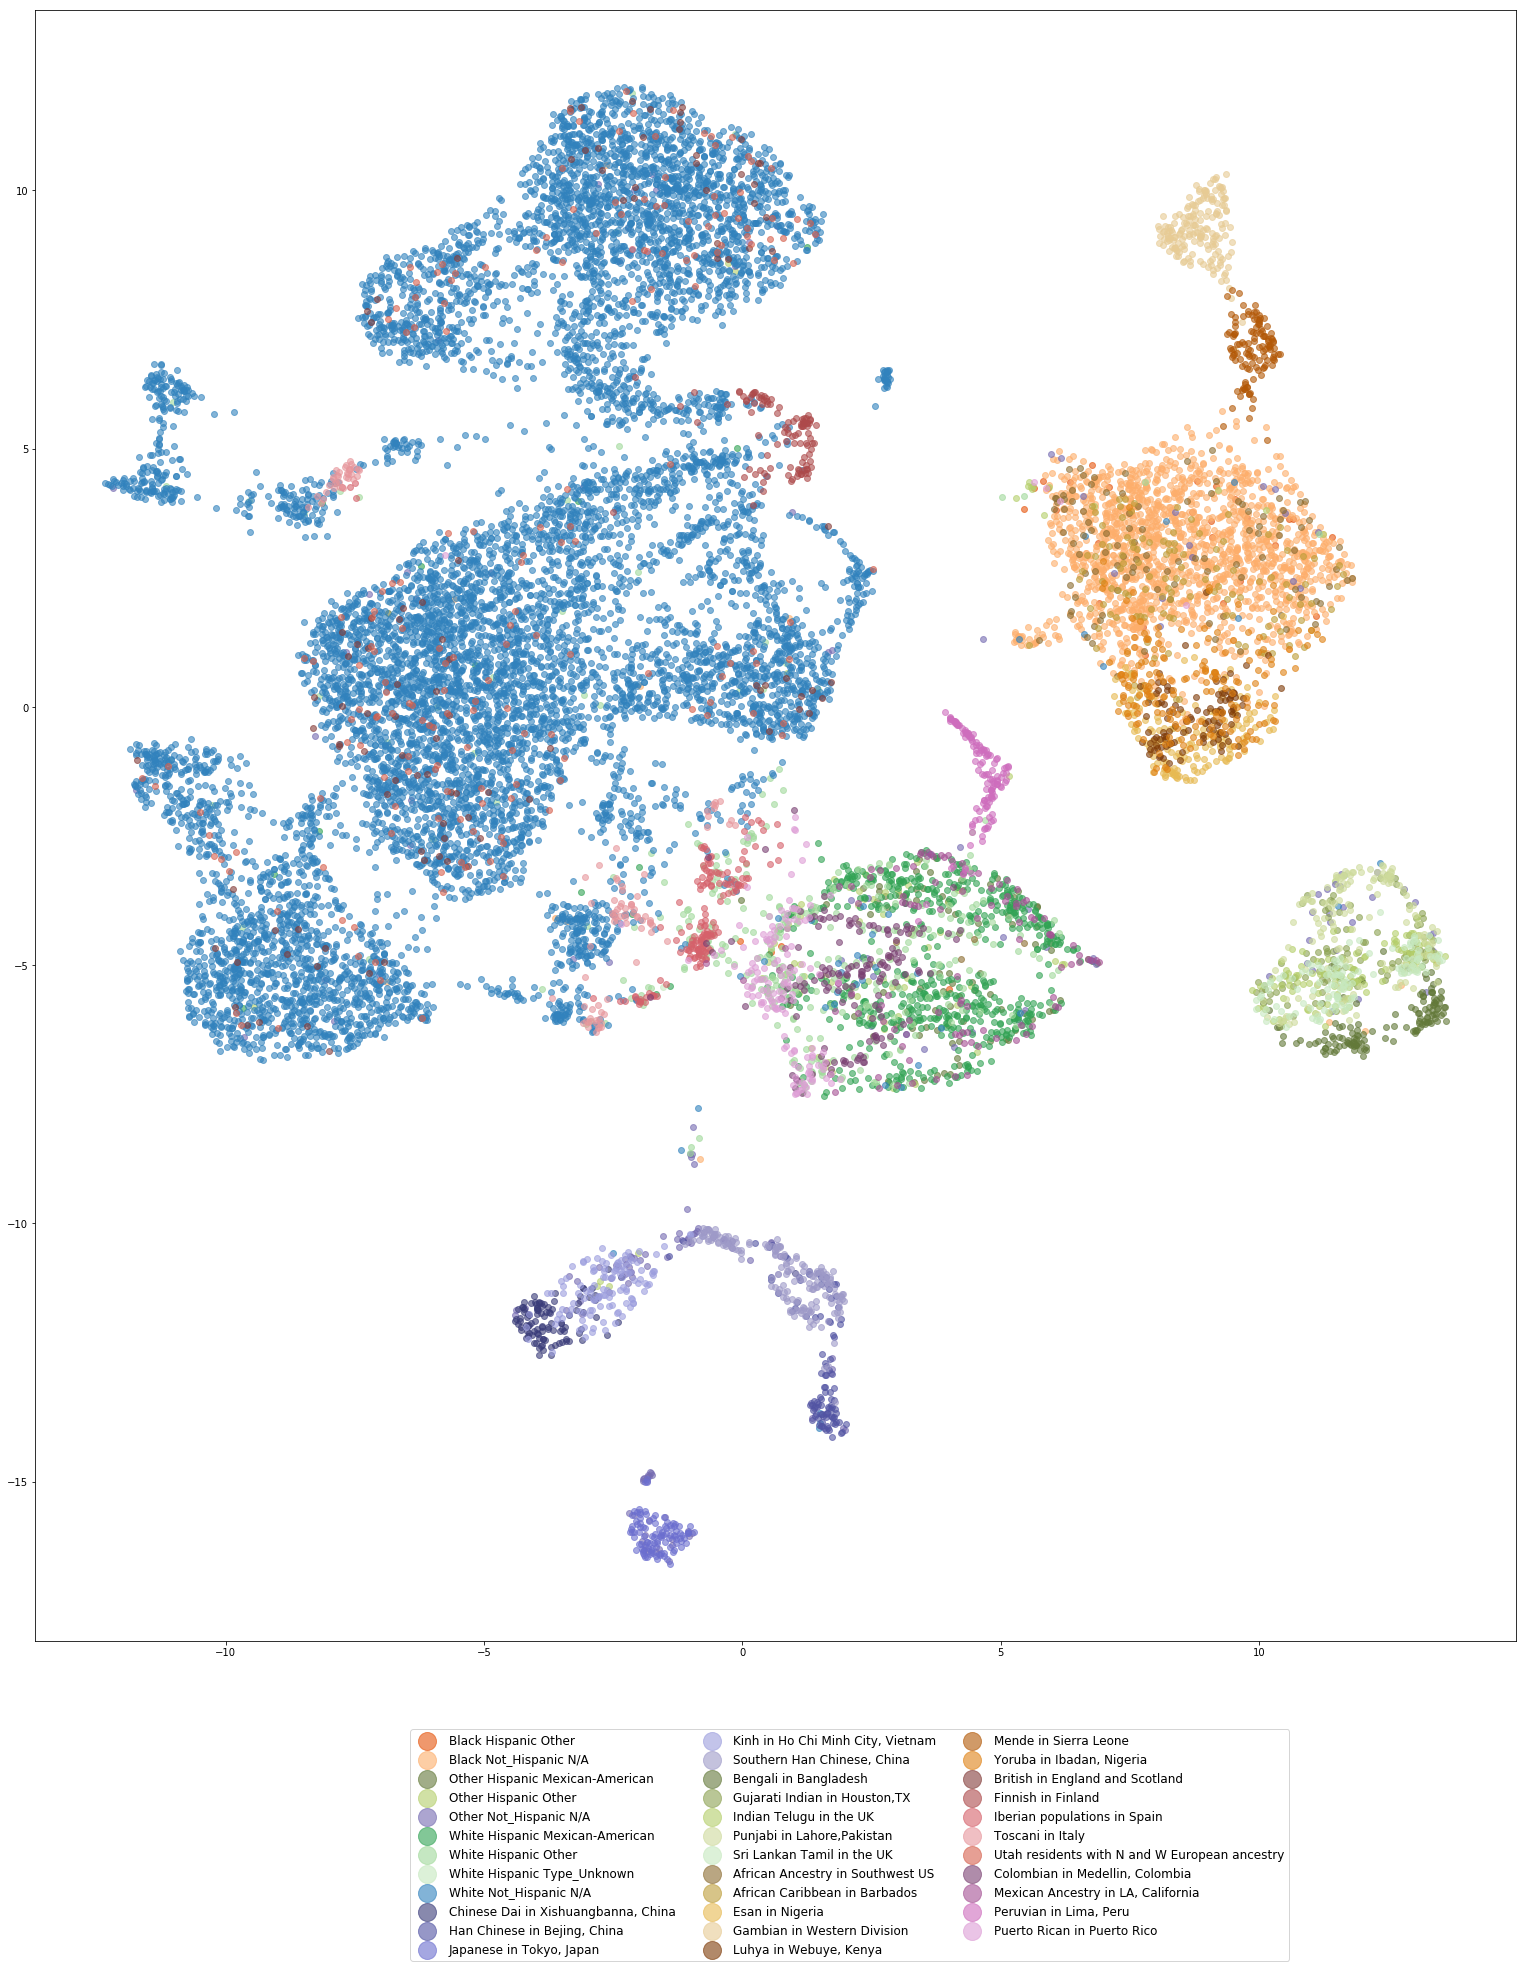

In [83]:
# One-off creations
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

proj_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'
out_dir = '/Volumes/Stockage/alex/hrs_1000G/images'

fname = 'HRS_1000G_UMAP_PC10_NC2_NN15_MD0.5_2018627203416'

temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

num_pcs = fname.split('PC')[1].split('_')[0]
num_nn = fname.split('NN')[1].split('_')[0]
md = fname.split('MD')[1].split('_')[0]

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

color_dict_hrs = color_dict_race_hisp_mex

#####

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    temp_proj = proj_data_hrs[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_hrs[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = proj_data_1000g[indices_of_population_members[pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6, color=color_dict[pop])
    
ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

#fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
#plt.close()

# Using new eigenvectors
Here we use PC transformations based on the first $n-1$ vectors. The $n^{th}$ observation is projected on this PC coordinate system.

In [ ]:
with open("/Volumes/Stockage/alex/gt-dimred/np1/projections/merged_1000G_HRS_n_minus_one_pca.eigenvec") as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array = np.array(pca_data).astype(np.float)

We want to generate a UMAP embedding based on these $n-1$ points alone.

In [ ]:
pca_data_array.shape

In [ ]:
# Specify directories
obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"

In [ ]:
# Specify parameters for UMAP
nc = 2
nn = 15
md = 0.5

# Specify the number of PCs to use
pc = 10

# Suffix for filename
suffix = "pca15903_umap15903"

In [ ]:
tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

# Generate filename
fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md) + "_" + suffix + \
"_" + tstamp

# Project the above to 2D using UMAP and then project the last point using the embedding
umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,verbose=True)
umap_proj = umap_obj.fit_transform(pca_data_array[:,:pc])

save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
np.savetxt(os.path.join(proj_dir, fname), umap_proj)

Import the $n^{th}$ observation. This observation was projected onto the PC space of the prior $n-1$ points.

In [ ]:
umap_obj

In [ ]:
# Test out with an arbitrarily selected observation
umap_proj_temp = umap_obj.transform(X=np.matrix(pca_data_array[1,:10]))

In [ ]:
umap_proj_temp

In [ ]:
# Import the nth observation
with open("/Volumes/Stockage/alex/gt-dimred/np1/projections/merged_1000G_HRS_n_pca.eigenvec") as pc:
    pca_contents = pc.readlines()

nth_pca_data = []

for pc in pca_contents:
    nth_pca_data.append(pc.split()[2:len(pc)])

nth_pca_data = np.array(nth_pca_data).astype(np.float)

In [ ]:
nth_pca_data[:,:10]

In [ ]:
# Use this UMAP embedding to project the last item
umap_proj_obs_n = umap_obj.transform(X = np.matrix(nth_pca_data[:,:10]))

In [ ]:
umap_proj_obs_n

Plot the results

# N+1 but now the 1 is > 1
Less obtusely: I ran PCA on the HRS and projected the 1KGP onto that. See what the PCA looks like and then UMAP it. So basically this is the N + 3450 problem now.

In [ ]:
with open("/Volumes/Stockage/alex/gt-dimred/np1/merged_1000G_HRS_np1_pca_2.eigenvec") as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array = np.array(pca_data).astype(np.float)

We want to generate a UMAP embedding based on these $n-1$ points alone.

In [ ]:
pca_data_array.shape

In [ ]:
# Specify directories
obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"

In [ ]:
# Specify parameters for UMAP
nc = 2
nn = 15
md = 0.5

# Specify the number of PCs to use
pc = 10

# Suffix for filename
suffix = "pca_1kgp_onto_hrs_umap_1kgp_onto_hrs"

tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

# Generate filename
fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md) + "_" + suffix + \
"_" + tstamp

umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,
                     verbose=True).fit(pca_data_array[0:(len(aux_data_hrs)-1),:pc])
umap_proj = umap_obj.transform(pca_data_array[:,:pc])

save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
np.savetxt(os.path.join(proj_dir, fname), umap_proj)

In [31]:
# Define a colour scheme for the HRS with 1KGP projection. Emphasizing the Hispanic populations and Finns/Iberians/
# Toscani. Specify other clusters as more generic shared ancestry ("Asian ancestry", "African ancestry", etc)
color_dict_1000g_hrs = color_dict_1000g
color_dict_1000g_hrs["PEL"] = "#6B33FF"
color_dict_1000g_hrs["MXL"] = "#D133FF"
color_dict_1000g_hrs["CLM"] = "#FF33BE"
color_dict_1000g_hrs["PUR"] = "#FF3352"
color_dict_1000g_hrs["FIN"] = "#0B02BE"
color_dict_1000g_hrs["IBS"] = "#AF1E2A"
color_dict_1000g_hrs["CEU"] = "#1EAFA8"
color_dict_1000g_hrs["GBR"] = "#054E4A"

In [ ]:
# General plotting (one-off) of HRS with 1KGP projected onto it
fname = "HRS_1000G_NP1_UMAP_PC10_NC2_NN15_MD0.5_pca_1kgp_onto_hrs_umap_1kgp_onto_hrs_2018112224532"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"
out_dir = "/Volumes/Stockage/alex/hrs_1000G/images"

# One-off creations
eth = 'race_hisp_mex'

#temp_proj = test_proj
temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.2,
               color='grey', marker='x')

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = proj_data_1000g[indices_of_population_members[pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6,
                   color=color_dict_1000g_hisp[pop])


#ax.axis('off')

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

#fig.savefig(os.path.join(out_dir, fname + '_custom_label.jpeg'),format='jpeg')
#plt.close()

# Labelled plots

In [ ]:
fname = "HRS_1000G_NP1_UMAP_PC10_NC2_NN15_MD0.5_pca_1kgp_onto_hrs_umap_1kgp_onto_hrs_2018112221116"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"
out_dir = "/Volumes/Stockage/alex/hrs_1000G/images"

# One-off creations
eth = 'race_hisp_mex'

#temp_proj = test_proj
temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.2, color='grey', marker='x')

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = proj_data_1000g[indices_of_population_members[pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6,
                   color=color_dict_1000g_hisp[pop])

# Manually label populations on plot
temp_pop = "PEL"
ax.text(0, 10, temp_pop,fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "MXL"
ax.text(1.5, 8, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "CLM"
ax.text(1.8, 6, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "PUR"
ax.text(1.7, 4, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "TSI"
ax.text(-5.5, 3, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "IBS"
ax.text(1.5, 2.5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "FIN"
ax.text(-2.2, -0.5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
ax.text(4.55, 0.5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "GBR"
ax.text(4.2, -6.1, "GBR/", fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = "CEU"
ax.text(6.25, -6.1, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

# Manually label other clusters
ax.text(-2, 14, "AFR", fontdict={"color": "#AF811E", "size": 30})
ax.text(-30.6, 1, "EAS", fontdict={"color": "#0F0972", "size": 30})
ax.text(8, 10, "SAS", fontdict={"color": "#09720E", "size": 30})

ax.axis('off')

#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_custom_label.jpeg'),format='jpeg')
#plt.close()

In [ ]:
fname = "HRS_1000G_NP1_UMAP_PC10_NC2_NN15_MD0.5_pca_1kgp_onto_hrs_umap_1kgp_onto_hrs_2018112221116"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"
out_dir = "/Volumes/Stockage/alex/hrs_1000G/images"

# One-off creations
eth = 'race_hisp_mex'

temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], alpha=0.4,
               color = [color_list_admix[i] for i in indices_of_population_members_dict_hrs[eth][pop]])

ax.axis('off')

#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_admix.jpeg'),format='jpeg')
#plt.close()

In [ ]:
# Same as above, but with ethnicity proxy as a colouring scheme
# One-off creations
# Labels for HRS
eth = 'race_hisp_mex'

temp_proj = test_proj

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in ['W_N_N','B_N_N','W_H_M','W_H_O','O_N_N','O_H_M','O_H_O','B_H_O','W_H_U']:
    temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.6,
               color = color_dict_race_hisp_mex[pop], s = 40)

temp_pop = "W_N_N"
ax.text(-10, -2, "WNH", fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "B_N_N"
ax.text(-1.8, 12, "BNH", fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "B_H_O"
ax.text(-2.6, 13, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "W_H_M"
ax.text(-5.8, 9, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
ax.text(1.4, 8, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "O_H_M"
ax.text(-2.8, 11, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
ax.text(1.4, 7, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "W_H_O"
ax.text(1.6, 4.5, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "O_N_N"
ax.text(-31, 1, "ONH", fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
#ax.text(-7, 3.5, "ONH", fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})
temp_pop = "O_H_O"
ax.text(-31, 0, temp_pop.replace("_",""), fontdict={"color": color_dict_race_hisp_mex[temp_pop], "size": 30})

ax.axis('off')

#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_' + eth + '_labels.jpeg'),format='jpeg')
#plt.close()

In [ ]:
# Same as above, but with ethnicity proxy as a colouring scheme
# One-off creations
# Labels for HRS
eth = 'born'

fname = "HRS_1000G_NP1_UMAP_PC10_NC2_NN15_MD0.5_pca_1kgp_onto_hrs_umap_1kgp_onto_hrs_2018112221116"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"
out_dir = "/Volumes/Stockage/alex/hrs_1000G/images"

temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.6,
               color = color_dict_born[pop], s = 40)

ax.axis('off')

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

#fig.savefig(os.path.join(out_dir, fname + '_' + eth + '_born.jpeg'),format='jpeg')
#plt.close()

In [ ]:
name_by_code

# Hispanic + 1KGP
We can take the above approach to project 1KGP data onto the Hispanic-identified population in the HRS. To do this, we need indices of the Hispanic population. Then we can use PLINK to use the Hispanic population to create PC axes and project the rest to that.

In [ ]:
# This gives a list of all individuals identified as Hispanic in the HRS
id_list_hispanic = hrs_joined.index[hrs_joined["HispanicStatus"]=="Hispanic"].tolist()

In [ ]:
hrs_joined.index[hrs_joined["HispanicStatus"]=="Hispanic"].tolist()

In [ ]:
# Generate the ID list of the HRS. Default value is "2" (ie don't use for PCA)
id_list_hrs = hrs_joined[["FamID","IndID"]].values.tolist()
id_list_hrs = [i + [2] for i in id_list_hrs]

In [ ]:
# Change Hispanic indices to "1" (ie use it for PCA)
for i in id_list_hispanic:
    id_list_hrs[i][2]=1

In [ ]:
# Create a list of IDs for 1KGP
# Same as before but try creating an HRS-only projection
id_list_1kpg = list()

# Get a list of all but the last ID
for key in individuals_by_population.keys():
    id_list_1kpg += individuals_by_population[key]

# Family IDs and individual IDs are the same in this file
id_list_1kpg = [[i] + [i] + [2] for i in id_list_1kpg]

# Combine the ID lists
id_list_full = id_list_hrs + id_list_1kpg

In [ ]:
out_dir = '/Volumes/Stockage/alex/gt-dimred/np1'

with open(os.path.join(out_dir, "np1_id_list_hrs_hisp.txt"),"w") as filehandle:
    filehandle.writelines("%s\n" % " ".join(map(str,ident)) for ident in id_list_full)

Code below will import the PCs generated using the IDs above.

In [ ]:
with open("/Volumes/Stockage/alex/gt-dimred/np1/merged_1000G_HRS_np1_pca_HISP.eigenvec") as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array_hisp = np.array(pca_data).astype(np.float)

Subset the PCs and grab the Hispanic data only as well as the Hispanic + 1KGP data only.

In [ ]:
pca_data_array_hisp_only = pca_data_array_hisp[id_list_hispanic,:]

id_list_1kgp = list(range((len(pca_data_array_hisp) - 3450), len(pca_data_array_hisp)))
pca_data_array_hisp_1kgp = pca_data_array_hisp[id_list_hispanic + id_list_1kgp, :]

In [ ]:
# Specify directories
obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"

In [ ]:
# Specify parameters for UMAP
nc = 2
nn = 15
md = 0.5

# Specify the number of PCs to use
pc = 7

# Suffix for filename
suffix = "pca_hrshisp_added1kgp"

In [ ]:
tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

# Generate filename
fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md) + "_" + suffix + \
"_" + tstamp

# Project the above to 2D using UMAP and then project the last point using the embedding
umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,verbose=True).fit(pca_data_array_hisp_only[:,:pc])
umap_proj = umap_obj.transform(pca_data_array_hisp[:,:pc])

save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
np.savetxt(os.path.join(proj_dir, fname), umap_proj)

In [ ]:
# Define the Hispanic populations to project.
# (luckily they're just the American ones)
# Also add the Spanish/italian pops
hispanic_pops = pop_by_continent['AMR'] + ['IBS','TSI']
hispanic_pops

In [ ]:
eth_proxy_dict['born']

In [ ]:
# Same as above, but HRS Hispanics only

proj_dir = '/Volumes/Stockage/alex/gt-dimred/np1/projections'
out_dir = '/Volumes/Stockage/alex/gt-dimred/np1/images'
fname = 'HRS_1000G_NP1_UMAP_PC7_NC2_NN15_MD0.5_pca_hrshisp_added1kgp_2018115153245'
eth = 'born'

#temp_proj = umap_proj
temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    # Take the intersection of the list of Hispanic IDs and HRS IDs
    temp_proj = proj_data_hrs[list(set(indices_of_population_members_dict_hrs[eth][pop]) & set(id_list_hrs_hispanic))]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.8,
               color=color_dict_born[pop], s = 100)


rect = patches.Rectangle((28,33.7), 4.5, 4.5, linewidth = 2, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

ax.axis('off')
#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_highlighted.jpeg'),format='jpeg')
#plt.close()

In [ ]:
name_by_code

In [ ]:
# Same as above, but HRS Hispanics only

proj_dir = '/Volumes/Stockage/alex/gt-dimred/np1/projections'
out_dir = '/Volumes/Stockage/alex/gt-dimred/np1/images'
fname = 'HRS_1000G_NP1_UMAP_PC7_NC2_NN15_MD0.5_pca_hrshisp_added1kgp_2018115153245'
eth = 'born'

#temp_proj = umap_proj
temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    # Take the intersection of the list of Hispanic IDs and HRS IDs
    temp_proj = proj_data_hrs[list(set(indices_of_population_members_dict_hrs[eth][pop]) & set(id_list_hrs_hispanic))]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.8,
               color = [color_list_admix[i] for i in \
                        list(set(indices_of_population_members_dict_hrs[eth][pop]) & set(id_list_hrs_hispanic))],
               s = 100)


#rect = patches.Rectangle((28,33.7), 4.5, 4.5, linewidth = 2, edgecolor = 'k', facecolor = 'none')
#ax.add_patch(rect)

ax.axis('off')
#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_admix.jpeg'),format='jpeg')
#plt.close()

In [ ]:
hispanic_pops

In [ ]:
proj_dir = '/Volumes/Stockage/alex/gt-dimred/np1/projections'
out_dir = '/Volumes/Stockage/alex/gt-dimred/np1/images'
fname = 'HRS_1000G_NP1_UMAP_PC7_NC2_NN15_MD0.5_pca_hrshisp_added1kgp_2018115153245'
eth = 'born'

#temp_proj = umap_proj
temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_dict[eth]):
    # Take the intersection of the list of Hispanic IDs and HRS IDs
    temp_proj = proj_data_hrs[list(set(indices_of_population_members_dict_hrs[eth][pop]) & set(id_list_hrs_hispanic))]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_labels_dict[eth][pop], alpha=0.6,
               color=color_dict_born[pop], s = 100)

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        if pop in hispanic_pops:
            temp_proj = proj_data_1000g[indices_of_population_members[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.8,
                       color=color_dict_1000g_hrs[pop],
                      marker = 'X', s = 100)

rect = patches.Rectangle((28,33.7), 4.5, 4.5, linewidth = 2, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

temp_pop = 'MXL'
ax.text(29, 31.5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = 'CLM'
ax.text(22.5, 30, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = 'PEL'
ax.text(25, 32, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = 'PUR'
ax.text(20, 26, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = 'IBS'
ax.text(21.4, 22, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
temp_pop = 'TSI'
ax.text(22, 22, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

ax.axis('off')
#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

fig.savefig(os.path.join(out_dir, fname + '_1kgp_hisp.jpeg'),format='jpeg')
#plt.close()

In [ ]:
# Look at the PCA projection
aux_to_use = aux_data_5

# One-off creations
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

temp_proj = pca_data_array_hisp

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

#####

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    # Take the intersection of the list of Hispanic IDs and HRS IDs
    #temp_proj = proj_data_hrs[indices_of_population_members_hrs[pop]]
    temp_proj = proj_data_hrs[list(set(indices_of_population_members_hrs[pop]) & set(id_list_hrs_hispanic))]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.5, color=color_dict_born[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = proj_data_1000g[indices_of_population_members[pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.3, color=color_dict[pop])
    
ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

#fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
#plt.close()

In [ ]:
# Create HTML
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

temp_proj = umap_proj

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

p = figure(plot_width=1500, plot_height=1200)

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    proj_pop = proj_data_hrs[list(set(indices_of_population_members_hrs[pop]) & set(id_list_hrs_hispanic))]
    p.circle(proj_pop[:,0], proj_pop[:,1], legend=pop_dict[pop],
             color = color_dict_born[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        proj_pop = proj_data_1000g[indices_of_population_members[pop]]
        p.circle(proj_pop[:,0], proj_pop[:,1], 
                 legend=name_by_code[pop], color = color_dict[pop])

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file("hrs_hisp_test.html")

show(p)

In [ ]:
# Drop the non-Hispanic HRS population.
pca_data_array_hisp_only = pca_data_array_hisp[id_list_hispanic,:]

# The 1KGP observations are the last 3450
id_list_1kgp = list(range((len(pca_data_array_hisp) - 3450), len(pca_data_array_hisp)))
pca_data_array_hisp_1kgp = pca_data_array_hisp[id_list_hispanic + id_list_1kgp, :]

In [ ]:
pca_data_array_hisp_1kgp.shape

In [ ]:
tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

# Generate filename
fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md) + "_" + suffix + \
"_" + tstamp

# Project the above to 2D using UMAP and then project the last point using the embedding
umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,verbose=True).fit(pca_data_array_hisp_only[:,:10])
umap_proj = umap_obj.transform(pca_data_array_hisp_1kgp[:,:pc])

save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
np.savetxt(os.path.join(proj_dir, fname), umap_proj)

In [ ]:
# Test to see if we can use the whole dataset

# Project the above to 2D using UMAP and then project the last point using the embedding
#umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,verbose=True).fit(pca_data_array_hisp_only[:,:10])
umap_proj = umap_obj.transform(pca_data_array_hisp_1kgp[:,:pc])

#save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
#np.savetxt(os.path.join(proj_dir, fname), umap_proj)

# 3D

In [ ]:
# Import plotly for 3D exploration
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
from plotly.graph_objs import Scatter, Layout

Play a bit with the 1KGP data projected onto the HRS embedding

In [ ]:
with open("/Volumes/Stockage/alex/gt-dimred/np1/merged_1000G_HRS_np1_pca_2.eigenvec") as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array = np.array(pca_data).astype(np.float)

In [ ]:
# Specify directories
obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"

# Specify parameters for UMAP
nc = 3 # Want to project to 3D
nn = 5
md = 0.01

# Specify the number of PCs to use
pc = 10

# Suffix for filename
suffix = "pca_1kgp_onto_hrs_umap_1kgp_onto_hrs"

tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

# Generate filename
fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md).replace(",","") \
+ "_" + suffix + "_" + tstamp

umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,
                     verbose=True).fit(pca_data_array[0:(len(aux_data_hrs)-1),:pc])
umap_proj = umap_obj.transform(pca_data_array[:,:pc])

save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
np.savetxt(os.path.join(proj_dir, fname), umap_proj)

In [ ]:
eth = 'born'

temp_color_dict = color_dict_born
#temp_color_dict = color_dict_race_hisp_mex

# Create a blank list of what to plot
traces = []

# Make sure to split out data into HRS and 1KGP indices
proj_data_hrs = umap_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = umap_proj[len(aux_data_hrs)-1:,:]

# First go through the HRS data
for pop in sorted(eth_proxy_dict[eth]):
    proj_subset = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
    color_string = str(int('0x' + temp_color_dict[pop][1:3].upper(),16)) + ',' + \
    str(int('0x' + temp_color_dict[pop][3:5].upper(),16)) + ',' + \
    str(int('0x' + temp_color_dict[pop][5:7].upper(),16))
    
    temp_trace = go.Scatter3d(
        x=proj_subset[:,0],
        y=proj_subset[:,1],
        z=proj_subset[:,2],
        #name=race_dict_rev[pop[0]] + ' ' + hisp_dict_rev[pop[2]] + ' ' + mex_dict_rev[pop[-1]],
        name=brn_dict_rev[pop],
        mode='markers',
        marker=dict(
            size=2,
            color='rgba('+color_string+',0.9)',
            line=dict(
                color='rgb('+color_string+')',
                width=2
            )
        )
    
    )
    traces.append(temp_trace)

for cont in continents:
    for pop in pop_by_continent[cont]:
        proj_subset = proj_data_1000g[indices_of_population_members[pop]]

        color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][5:7].upper(),16))
        
        temp_trace = go.Scatter3d(
            x=proj_subset[:,0],
            y=proj_subset[:,1],
            z=proj_subset[:,2],
            name=name_by_code[pop],
            mode='markers',
            marker=dict(
                size=2,
                color='rgba('+color_string+',0.9)',
                line=dict(
                    color='rgb('+color_string+')',
                    width=2
                )
            )
        )
        traces.append(temp_trace)
        
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='test_hrs_1kgp_3d.html')

In [971]:
# Do a grid search
# Specify directories
nn_list = [5, 15, 30, 50]
md_list = [0.001, 0.01, 0.1, 0.5]

obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects"
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections"

# Specify parameters for UMAP
nc = 3 # Want to project to 3D

# Specify the number of PCs to use
pc = 15

# Suffix for filename
suffix = "pca_1kgp_onto_hrs_umap_1kgp_onto_hrs"

for nn in nn_list:
    for md in md_list:
        tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

        # Generate filename
        fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + "_MD" + str(md).replace(".","") \
        + "_" + suffix + "_" + tstamp

        umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,
                             verbose=True).fit(pca_data_array[0:(len(aux_data_hrs)-1),:pc])
        umap_proj = umap_obj.transform(pca_data_array[:,:pc])

        save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
        np.savetxt(os.path.join(proj_dir, fname), umap_proj)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.001, n_components=3, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
Construct embedding


/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.01, n_components=3, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



 0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, tr

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



 0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=3, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, tr

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



 0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.001, n_components=3, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5,

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=3, n_epochs=None,
   n_neighbors=30, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

In [ ]:
brn_dict_rev

In [ ]:
race_dict_rev, hisp_dict_rev, mex_dict_rev

In [ ]:
race_hisp_mex_dict = dict()

for rk in race_dict_rev.keys():
    for hk in hisp_dict_rev.keys():
        for mk in mex_dict_rev.keys():
            race_hisp_mex_dict[rk + "_" + hk + "_" + mk] = race_dict_rev[rk] + " " + hisp_dict_rev[hk] + " " + \
            mex_dict_rev[mk]

In [964]:
race_hisp_mex_dict

{'B_H_M': 'Black Hispanic Mexican-American',
 'B_H_N': 'Black Hispanic N/A',
 'B_H_O': 'Black Hispanic Other',
 'B_H_U': 'Black Hispanic Type_Unknown',
 'B_N_M': 'Black Not_Hispanic Mexican-American',
 'B_N_N': 'Black Not_Hispanic N/A',
 'B_N_O': 'Black Not_Hispanic Other',
 'B_N_U': 'Black Not_Hispanic Type_Unknown',
 'O_H_M': 'Other Hispanic Mexican-American',
 'O_H_N': 'Other Hispanic N/A',
 'O_H_O': 'Other Hispanic Other',
 'O_H_U': 'Other Hispanic Type_Unknown',
 'O_N_M': 'Other Not_Hispanic Mexican-American',
 'O_N_N': 'Other Not_Hispanic N/A',
 'O_N_O': 'Other Not_Hispanic Other',
 'O_N_U': 'Other Not_Hispanic Type_Unknown',
 'W_H_M': 'White Hispanic Mexican-American',
 'W_H_N': 'White Hispanic N/A',
 'W_H_O': 'White Hispanic Other',
 'W_H_U': 'White Hispanic Type_Unknown',
 'W_N_M': 'White Not_Hispanic Mexican-American',
 'W_N_N': 'White Not_Hispanic N/A',
 'W_N_O': 'White Not_Hispanic Other',
 'W_N_U': 'White Not_Hispanic Type_Unknown'}

In [ ]:
hrs_label_dict = defaultdict()
hrs_label_dict['born'] = brn_dict_rev
hrs_label_dict['race_hisp_mex'] = race_hisp_mex_dict

In [972]:
eth = 'race_hisp_mex'

html_dir = '/Volumes/Stockage/alex/gt-dimred/np1/html'
proj_dir = '/Volumes/Stockage/alex/gt-dimred/np1/projections'

temp_color_dict = color_meta_dict[eth]

for fname in os.listdir(proj_dir):
    if not os.path.isdir(os.path.join(proj_dir, fname)) and fname[:9]=='HRS_1000G' and fname.split('NC')[1][0]=='3':
        # Create a blank list of what to plot
        traces = []
        
        temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

        # Make sure to split out data into HRS and 1KGP indices
        proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
        proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

        # First go through the HRS data
        for pop in sorted(eth_proxy_dict[eth]):
            proj_subset = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
            color_string = str(int('0x' + temp_color_dict[pop][1:3].upper(),16)) + ',' + \
            str(int('0x' + temp_color_dict[pop][3:5].upper(),16)) + ',' + \
            str(int('0x' + temp_color_dict[pop][5:7].upper(),16))

            temp_trace = go.Scatter3d(
                x=proj_subset[:,0],
                y=proj_subset[:,1],
                z=proj_subset[:,2],
                name=hrs_label_dict[eth][pop],
                #name=brn_dict_rev[pop],
                mode='markers',
                marker=dict(
                    size=2,
                    color='rgba('+color_string+',0.9)',
                    line=dict(
                        color='rgb('+color_string+')',
                        width=2
                    )
                )

            )
            traces.append(temp_trace)

        for cont in continents:
            for pop in pop_by_continent[cont]:
                proj_subset = proj_data_1000g[indices_of_population_members[pop]]

                color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
                str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
                str(int('0x' + color_dict[pop][5:7].upper(),16))

                temp_trace = go.Scatter3d(
                    x=proj_subset[:,0],
                    y=proj_subset[:,1],
                    z=proj_subset[:,2],
                    name=name_by_code[pop],
                    mode='markers',
                    marker=dict(
                        size=2,
                        color='rgba('+color_string+',0.9)',
                        line=dict(
                            color='rgb('+color_string+')',
                            width=2
                        )
                    )
                )
                traces.append(temp_trace)

        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )

        fig = go.Figure(data=traces, layout=layout)
        plotly.offline.plot(fig, filename=os.path.join(html_dir, fname + '_' + eth + '.html'), auto_open=False)

# Test various combinations of PCs
Motivation: Would like to see if different combinations of PCs lead to different results

In [78]:
for i in range(0,10):
    obj_dir = "/Volumes/Stockage/alex/gt-dimred/umap_objects/experimental"
    proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections/experimental"
    out_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections/experimental"

    # Specify parameters for UMAP
    nc = 2

    # Specify which PCs to use
    #pc_list = list(range(2,21))
    pc_list = [5,6,7,8,9,10,11,12,13,14,15]

    md = 0.5
    nn = 15

    # Suffix for filename
    suffix = "pca_1kgp_onto_hrs_umap_1kgp_onto_hrs"

    for pc in pc_list:
    # Generate filename
        tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])
        fname = "HRS_1000G_NP1_UMAP_PC" + str(pc) + "_NC" + str(nc) + "_NN" + str(nn) + \
        "_MD" + str(md).replace(".","") + "_" + suffix + "_" + tstamp

        umap_obj = umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md,
                             verbose=True).fit(pca_data_array[0:(len(aux_data_hrs)-1),:pc])
        umap_proj = umap_obj.transform(pca_data_array[:,:pc])

        save_object(umap_obj, os.path.join(obj_dir, fname+'_umapobj'))
        np.savetxt(os.path.join(proj_dir, fname), umap_proj)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  / 

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Construct embedding


/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  / 

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  / 

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  / 

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

/Users/alex/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_we

In [79]:
color_dict_1000g_hisp = color_dict_1000g_hrs
color_dict_1000g_hisp["PEL"] = "#5408FB"
color_dict_1000g_hisp["PUR"] = "#FB1241"
color_dict_1000g_hisp["MXL"] = "#9B30C2"
color_dict_1000g_hisp["CLM"] = "#EC16A9"

In [80]:
proj_dir = "/Volumes/Stockage/alex/gt-dimred/np1/projections/experimental"
out_dir = "/Volumes/Stockage/alex/gt-dimred/np1/images/experimental"

# One-off creations
eth = 'race_hisp_mex'

for fname in os.listdir(proj_dir):
    temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

    proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
    proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111, aspect=1)

    # First loop is for HRS data
    for pop in sorted(eth_proxy_dict[eth]):
        temp_proj = proj_data_hrs[indices_of_population_members_dict_hrs[eth][pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.2, color='grey', marker='x')

    # Second loop is for 1000G data
    for cont in continents: 
        for pop in pop_by_continent[cont]:
            temp_proj = proj_data_1000g[indices_of_population_members[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6,
                       color=color_dict_1000g_hisp[pop])
            
    #ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0,-0.2), fontsize=12,markerscale=3)
    ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.5,-0.15), fontsize=12,markerscale=3)
    fig.savefig(os.path.join(out_dir, fname + '_' + eth + '.jpeg'),format='jpeg')
    plt.close()

# Sandbox

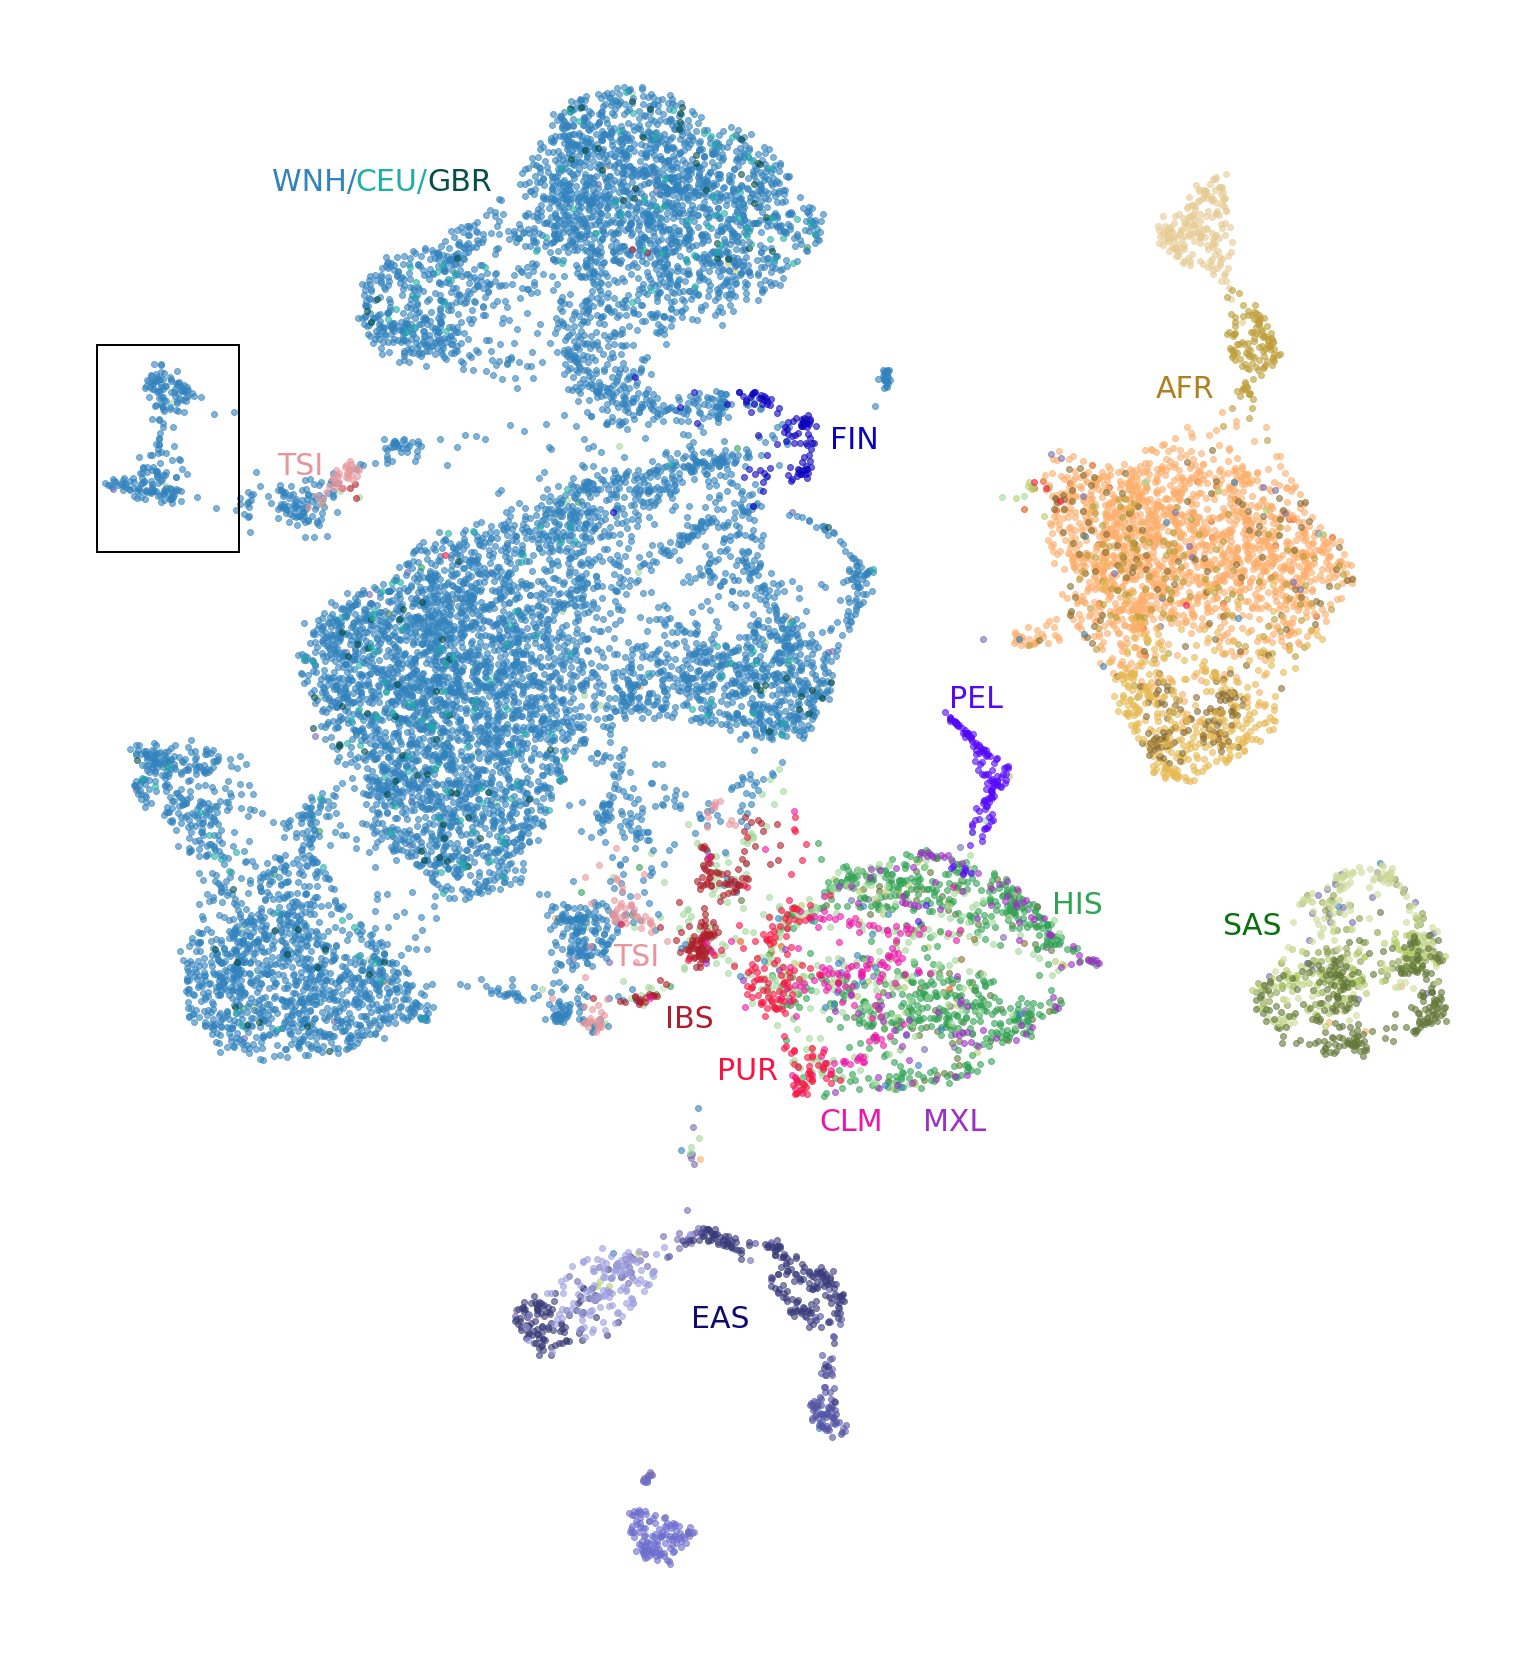

In [169]:
# Recreate an image in the manuscript
# One-off creations
# Labels for HRS
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'
elif aux_to_use == aux_data_7:
    aux_label = 'BORN_HISP'

proj_dir = '/Volumes/Stockage/alex/hrs_1000G/projections'
out_dir = '/Volumes/Stockage/alex/hrs_1000G/images/for_export'

fname = 'HRS_1000G_UMAP_PC10_NC2_NN15_MD0.5_2018627203416'

temp_proj = np.loadtxt(os.path.join(proj_dir, fname))

num_pcs = fname.split('PC')[1].split('_')[0]
num_nn = fname.split('NN')[1].split('_')[0]
md = fname.split('MD')[1].split('_')[0]

proj_data_hrs = temp_proj[0:(len(aux_data_hrs)-1),:]
proj_data_1000g = temp_proj[len(aux_data_hrs)-1:,:]

color_dict_hrs = color_dict_race_hisp_mex

#####

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, aspect=1)

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    temp_proj = proj_data_hrs[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_hrs[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        temp_proj = proj_data_1000g[indices_of_population_members[pop]]
        ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6, color=color_dict_1000g_hrs[pop])
    
#ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.2), fontsize=12,markerscale=3)

# Add a rectangle for the WNH population without other Europeans
rect = patches.Rectangle((-12.5,3), 2.75, 4, linewidth = 2, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

temp_pop = 'FIN'
ax.text(1.7, 5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'TSI'
ax.text(-9, 4.5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})
ax.text(-2.5, -5, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'IBS'
ax.text(-1.5, -6.2, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'PUR'
ax.text(-0.5, -7.2, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'CLM'
ax.text(1.5, -8.2, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'MXL'
ax.text(3.5, -8.2, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = 'PEL'
ax.text(4, 0, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

# Super-population labelling
temp_pop = 'AFR'
ax.text(8, 6, temp_pop, fontdict={"color": "#AF811E", "size": 30})

temp_pop = 'SAS'
ax.text(9.3, -4.4, temp_pop, fontdict={"color": "#09720E", "size": 30})

temp_pop = 'EAS'
ax.text(-1, -12, temp_pop, fontdict={"color": "#0F0972", "size": 30})

temp_pop = 'HIS'
ax.text(6, -4, temp_pop, fontdict={"color": color_dict_hrs["W_H_M"], "size": 30})

temp_pop = "WNH"
ax.text(-9.1, 10, temp_pop + "/", fontdict={"color": color_dict_hrs["W_N_N"], "size": 30})

temp_pop = "CEU"
ax.text(-7.5, 10, temp_pop + "/", fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

temp_pop = "GBR"
ax.text(-6.1, 10, temp_pop, fontdict={"color": color_dict_1000g_hrs[temp_pop], "size": 30})

ax.axis("off")

fig.savefig(os.path.join(out_dir, fname + '_label.jpeg'),format='jpeg')
#plt.close()

# Sandbox

In [172]:
test_obj = pickle.load(open("/Volumes/Stockage/alex/gt-dimred/umap_objects/experimental/HRS_1000G_NP1_UMAP_PC2_NC2_NN15_MD05_pca_1kgp_onto_hrs_umap_1kgp_onto_hrs_201811920107_umapobj","rb"))

In [173]:
test_obj

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)

In [ ]:
test_obj.

# Comparing t-SNE and UMAP HRS projections

In [31]:
# Compare the following three:
# UMAP on 10 PCs
# t-SNE on 10 PCs (default, 5000 iterations)
# t-SNE on 10 PCs (seeded by UMAP, 5000 iterations)

hrs_dir = "/Volumes/Stockage/alex/hrs/projections"
fname_umap = "HRS_UMAP_PC10_NC2_NN15_MD0.5_20181024172559"
fname_tsne_default = "HRS_TSNE_PCs_SEED_PC10_ITER5000_201812422654"
fname_tsne_umap = "HRS_TSNE_UMAP_SEED_PC10_ITER5000_201812423815"

out_dir = "/Users/alex/Documents/Ethnicity/ms/images"

umap_proj = np.loadtxt(os.path.join(hrs_dir, fname_umap))
tsne_proj = np.loadtxt(os.path.join(hrs_dir, fname_tsne_default))
tsne_umap_proj = np.loadtxt(os.path.join(hrs_dir, fname_tsne_umap))

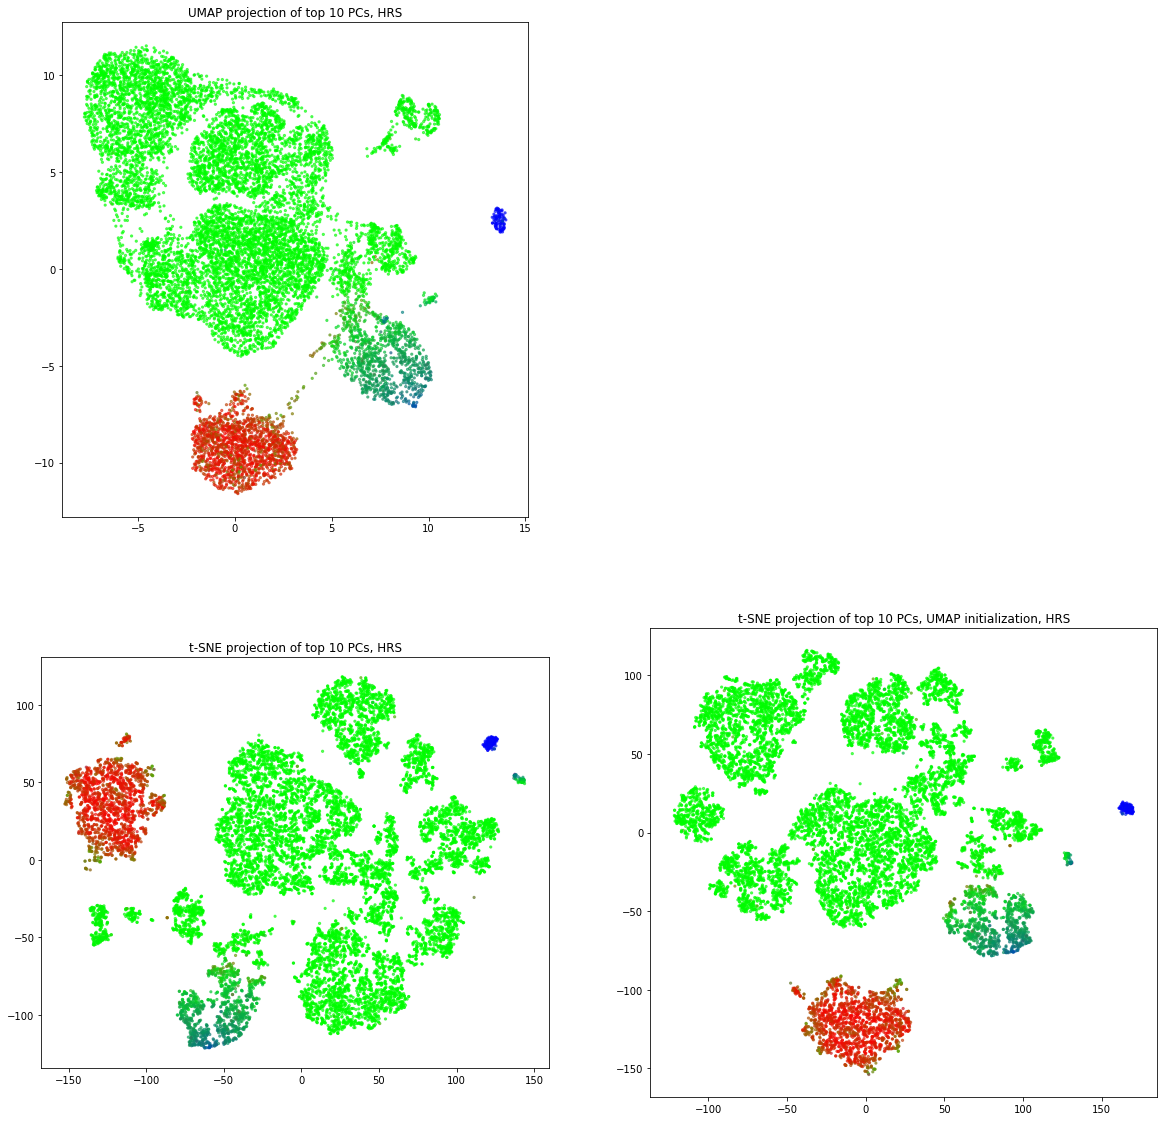

In [42]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(221, aspect=1)

proj = umap_proj

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, s =5,
               color=[color_list_admix[i] for i in indices_of_population_members_hrs[pop]])

ax.set_title("UMAP projection of top 10 PCs, HRS")

ax = fig.add_subplot(223, aspect=1)

proj = tsne_proj

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, s =5,
               color=[color_list_admix[i] for i in indices_of_population_members_hrs[pop]])

ax.set_title("t-SNE projection of top 10 PCs, HRS")

ax = fig.add_subplot(224, aspect=1)

proj = tsne_umap_proj

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, s =5,
               color=[color_list_admix[i] for i in indices_of_population_members_hrs[pop]])

ax.set_title("t-SNE projection of top 10 PCs, UMAP initialization, HRS")

fig.savefig(os.path.join(out_dir, "HRS_tsne_umap.jpeg"),format="jpeg")